**df处理label列，把其转化成 0, 1**
```python
df['Output'] = df['Output'].replace({'True': 1, 'False': 0})
```

**df处理某一列中的字符串，删除或替换某个字符**
```python
df['column_name'] = df['column_name'].str.replace('[', '').str.replace(']', '')
```


**df保存文件**
```python
df.to_csv('./output.csv',header = True, index = False)
```

**需要把读进来的字符串转化成数字**
```python
list(map(int, df['Output'].values.tolist()))
```
**或者直接**
```python
df['Output'].values
```

In [1]:
from transformers import AutoProcessor

tokenizer = AutoProcessor.from_pretrained("bert-base-cased")

print(tokenizer)

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [2]:
import torch.nn as nn

class BertClassifier(nn.Module):
    def __init__(self, num_classes, hidden_size=768, num_layers=12, num_heads=12, dropout=0.1):
        super(BertClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_size = hidden_size
        
        self.embedding = nn.Embedding(30000, self.embedding_size, padding_idx=0)
        self.position_encoding = nn.Embedding(512, self.embedding_size)
        self.segment_encoding = nn.Embedding(2, self.embedding_size)
        
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=self.embedding_size,
                nhead=self.num_heads,
                dim_feedforward=self.hidden_size * 4,
                dropout=dropout,
                activation='gelu'
            )
            for _ in range(self.num_layers)
        ])
        
        self.pooler = nn.Linear(self.hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        embeddings = self.embedding(input_ids) * math.sqrt(self.embedding_size)
        position_embeddings = self.position_encoding(torch.arange(embeddings.size(1), device=embeddings.device))[None, :, :].expand(embeddings.size(0), -1, -1)
        segment_embeddings = self.segment_encoding(token_type_ids)
        embeddings = embeddings + position_embeddings + segment_embeddings
        
        attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        attention_mask = attention_mask.repeat(1, self.num_heads, embeddings.size(1), 1)
        attention_mask = attention_mask.to(dtype=next(self.parameters()).dtype)
        attention_mask = (1.0 - attention_mask) * -10000.0
        
        for i in range(self.num_layers):
            embeddings = self.encoder_layers[i](embeddings, attention_mask)
        
        pooled_output = self.pooler(embeddings[:, 0])
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [14]:
class SQLDataset(Dataset):
    def __init__(self, sentences, tables, labels, tokenizer, max_length):
        self.sentences = sentences
        self.tables = tables
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        table = self.tables[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(
            f"{sentence} [SEP] {table}",
            return_tensors="pt",
            max_length=self.max_length,
            padding="max_length",
            truncation=True
        )
        inputs = {key: value.squeeze(0) for key, value in inputs.items()}  # Add this line
        inputs["labels"] = torch.tensor(label, dtype=torch.long)
        return inputs

In [31]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    seed=42,
    load_best_model_at_end=True,
)

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv(r"./data/data.csv")

In [7]:
sentences = df['Input'].values
tables = df['Table'].values
labels = df['Output'].values

In [10]:
import sklearn

In [11]:
from sklearn.model_selection import train_test_split

# 将数据分为训练集和验证集
sentences_train, sentences_val, tables_train, tables_val, labels_train, labels_val = train_test_split(
    sentences, tables, labels, test_size=0.2, random_state=42
)

In [38]:
from transformers import TrainerCallback

class LossCallback(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.learning_rates = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and "loss" in logs:
            self.losses.append(logs["loss"])
        if "learning_rate" in logs:
            self.learning_rates.append(logs["learning_rate"])

In [39]:
loss_callback = LossCallback()

In [40]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# 将句子、表格和标签列表传递给SQLDataset实例
train_dataset = SQLDataset(sentences_train, tables_train, labels_train, tokenizer, max_length=128)
val_dataset = SQLDataset(sentences_val, tables_val, labels_val, tokenizer, max_length=128)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Add this line
    callbacks=[loss_callback]
)

trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

  0%|          | 0/510 [00:00<?, ?it/s]

{'loss': 0.4793, 'learning_rate': 4.901960784313725e-05, 'epoch': 0.2}
{'loss': 0.3859, 'learning_rate': 4.803921568627452e-05, 'epoch': 0.39}
{'loss': 0.2408, 'learning_rate': 4.705882352941177e-05, 'epoch': 0.59}
{'loss': 0.244, 'learning_rate': 4.607843137254902e-05, 'epoch': 0.78}
{'loss': 0.2711, 'learning_rate': 4.5098039215686275e-05, 'epoch': 0.98}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.20720624923706055, 'eval_runtime': 0.9881, 'eval_samples_per_second': 203.418, 'eval_steps_per_second': 13.156, 'epoch': 1.0}
{'loss': 0.1995, 'learning_rate': 4.411764705882353e-05, 'epoch': 1.18}
{'loss': 0.1322, 'learning_rate': 4.313725490196079e-05, 'epoch': 1.37}
{'loss': 0.3384, 'learning_rate': 4.215686274509804e-05, 'epoch': 1.57}
{'loss': 0.1426, 'learning_rate': 4.11764705882353e-05, 'epoch': 1.76}
{'loss': 0.1683, 'learning_rate': 4.0196078431372555e-05, 'epoch': 1.96}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.23154453933238983, 'eval_runtime': 1.0231, 'eval_samples_per_second': 196.462, 'eval_steps_per_second': 12.706, 'epoch': 2.0}
{'loss': 0.1796, 'learning_rate': 3.9215686274509805e-05, 'epoch': 2.16}
{'loss': 0.1205, 'learning_rate': 3.8235294117647055e-05, 'epoch': 2.35}
{'loss': 0.1263, 'learning_rate': 3.725490196078432e-05, 'epoch': 2.55}
{'loss': 0.1557, 'learning_rate': 3.627450980392157e-05, 'epoch': 2.75}
{'loss': 0.142, 'learning_rate': 3.529411764705883e-05, 'epoch': 2.94}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.22262491285800934, 'eval_runtime': 1.0374, 'eval_samples_per_second': 193.752, 'eval_steps_per_second': 12.531, 'epoch': 3.0}
{'loss': 0.3747, 'learning_rate': 3.431372549019608e-05, 'epoch': 3.14}
{'loss': 0.0968, 'learning_rate': 3.3333333333333335e-05, 'epoch': 3.33}
{'loss': 0.1204, 'learning_rate': 3.235294117647059e-05, 'epoch': 3.53}
{'loss': 0.0868, 'learning_rate': 3.137254901960784e-05, 'epoch': 3.73}
{'loss': 0.0773, 'learning_rate': 3.0392156862745097e-05, 'epoch': 3.92}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.27010101079940796, 'eval_runtime': 1.1495, 'eval_samples_per_second': 174.861, 'eval_steps_per_second': 11.309, 'epoch': 4.0}
{'loss': 0.124, 'learning_rate': 2.9411764705882354e-05, 'epoch': 4.12}
{'loss': 0.0517, 'learning_rate': 2.8431372549019608e-05, 'epoch': 4.31}
{'loss': 0.0418, 'learning_rate': 2.7450980392156865e-05, 'epoch': 4.51}
{'loss': 0.0881, 'learning_rate': 2.647058823529412e-05, 'epoch': 4.71}
{'loss': 0.0388, 'learning_rate': 2.5490196078431373e-05, 'epoch': 4.9}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.2750371992588043, 'eval_runtime': 1.1324, 'eval_samples_per_second': 177.506, 'eval_steps_per_second': 11.48, 'epoch': 5.0}
{'loss': 0.0024, 'learning_rate': 2.4509803921568626e-05, 'epoch': 5.1}
{'loss': 0.0162, 'learning_rate': 2.3529411764705884e-05, 'epoch': 5.29}
{'loss': 0.0347, 'learning_rate': 2.2549019607843138e-05, 'epoch': 5.49}
{'loss': 0.0735, 'learning_rate': 2.1568627450980395e-05, 'epoch': 5.69}
{'loss': 0.0701, 'learning_rate': 2.058823529411765e-05, 'epoch': 5.88}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.28506577014923096, 'eval_runtime': 1.1476, 'eval_samples_per_second': 175.153, 'eval_steps_per_second': 11.328, 'epoch': 6.0}
{'loss': 0.0585, 'learning_rate': 1.9607843137254903e-05, 'epoch': 6.08}
{'loss': 0.0037, 'learning_rate': 1.862745098039216e-05, 'epoch': 6.27}
{'loss': 0.0096, 'learning_rate': 1.7647058823529414e-05, 'epoch': 6.47}
{'loss': 0.0436, 'learning_rate': 1.6666666666666667e-05, 'epoch': 6.67}
{'loss': 0.0052, 'learning_rate': 1.568627450980392e-05, 'epoch': 6.86}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.35932475328445435, 'eval_runtime': 1.1528, 'eval_samples_per_second': 174.36, 'eval_steps_per_second': 11.277, 'epoch': 7.0}
{'loss': 0.0197, 'learning_rate': 1.4705882352941177e-05, 'epoch': 7.06}
{'loss': 0.0467, 'learning_rate': 1.3725490196078432e-05, 'epoch': 7.25}
{'loss': 0.0779, 'learning_rate': 1.2745098039215686e-05, 'epoch': 7.45}
{'loss': 0.0476, 'learning_rate': 1.1764705882352942e-05, 'epoch': 7.65}
{'loss': 0.0261, 'learning_rate': 1.0784313725490197e-05, 'epoch': 7.84}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.2758682668209076, 'eval_runtime': 1.1606, 'eval_samples_per_second': 173.193, 'eval_steps_per_second': 11.202, 'epoch': 8.0}
{'loss': 0.0048, 'learning_rate': 9.803921568627451e-06, 'epoch': 8.04}
{'loss': 0.0296, 'learning_rate': 8.823529411764707e-06, 'epoch': 8.24}
{'loss': 0.001, 'learning_rate': 7.84313725490196e-06, 'epoch': 8.43}
{'loss': 0.0341, 'learning_rate': 6.862745098039216e-06, 'epoch': 8.63}
{'loss': 0.0119, 'learning_rate': 5.882352941176471e-06, 'epoch': 8.82}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.277161568403244, 'eval_runtime': 1.052, 'eval_samples_per_second': 191.07, 'eval_steps_per_second': 12.358, 'epoch': 9.0}
{'loss': 0.002, 'learning_rate': 4.901960784313726e-06, 'epoch': 9.02}
{'loss': 0.0034, 'learning_rate': 3.92156862745098e-06, 'epoch': 9.22}
{'loss': 0.0006, 'learning_rate': 2.9411764705882355e-06, 'epoch': 9.41}
{'loss': 0.0012, 'learning_rate': 1.96078431372549e-06, 'epoch': 9.61}
{'loss': 0.0007, 'learning_rate': 9.80392156862745e-07, 'epoch': 9.8}
{'loss': 0.0566, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/13 [00:00<?, ?it/s]

{'eval_loss': 0.28489792346954346, 'eval_runtime': 1.0151, 'eval_samples_per_second': 198.005, 'eval_steps_per_second': 12.806, 'epoch': 10.0}
{'train_runtime': 169.0155, 'train_samples_per_second': 47.451, 'train_steps_per_second': 3.017, 'train_loss': 0.1001550312793138, 'epoch': 10.0}


TrainOutput(global_step=510, training_loss=0.1001550312793138, metrics={'train_runtime': 169.0155, 'train_samples_per_second': 47.451, 'train_steps_per_second': 3.017, 'train_loss': 0.1001550312793138, 'epoch': 10.0})

In [21]:
import matplotlib.pyplot as plt

In [27]:
import numpy as np

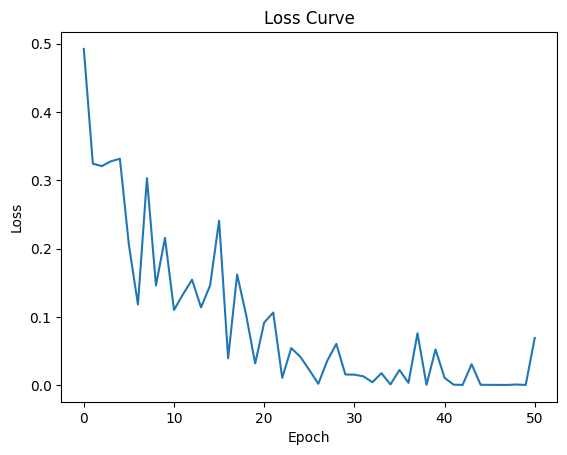

In [33]:
plt.plot(np.arange(len(loss_callback.losses)), loss_callback.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

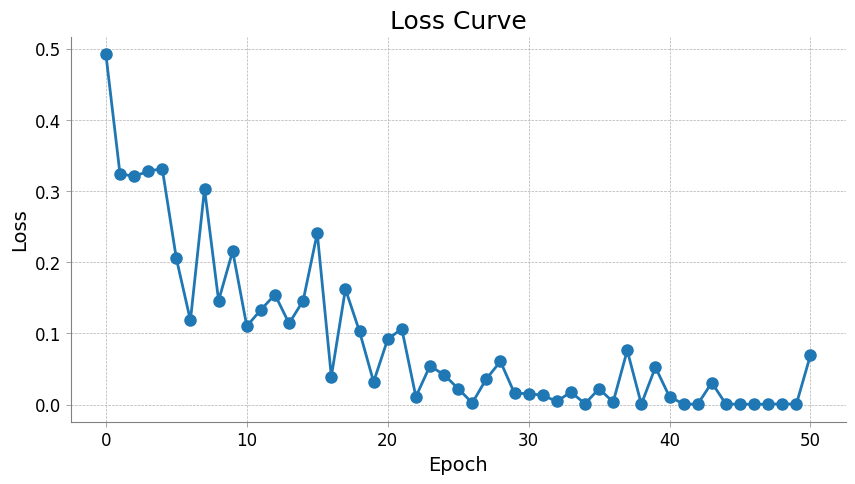

In [34]:
plt.figure(figsize=(10, 5))  # 设置图像大小
plt.plot(np.arange(len(loss_callback.losses)), loss_callback.losses, linewidth=2, marker='o', markersize=8)  # 设置线宽、标记和标记大小
plt.xlabel('Epoch', fontsize=14)  # 设置 x 轴标签和字体大小
plt.ylabel('Loss', fontsize=14)  # 设置 y 轴标签和字体大小
plt.title('Loss Curve', fontsize=18)  # 设置标题和字体大小
plt.grid(True, linestyle='--', linewidth=0.5)  # 添加网格线
plt.xticks(fontsize=12)  # 设置 x 轴刻度字体大小
plt.yticks(fontsize=12)  # 设置 y 轴刻度字体大小

# 添加轴标签、标记和线条的颜色
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')
plt.gca().xaxis.set_tick_params(width=0.5, color='gray')
plt.gca().yaxis.set_tick_params(width=0.5, color='gray')

plt.show()

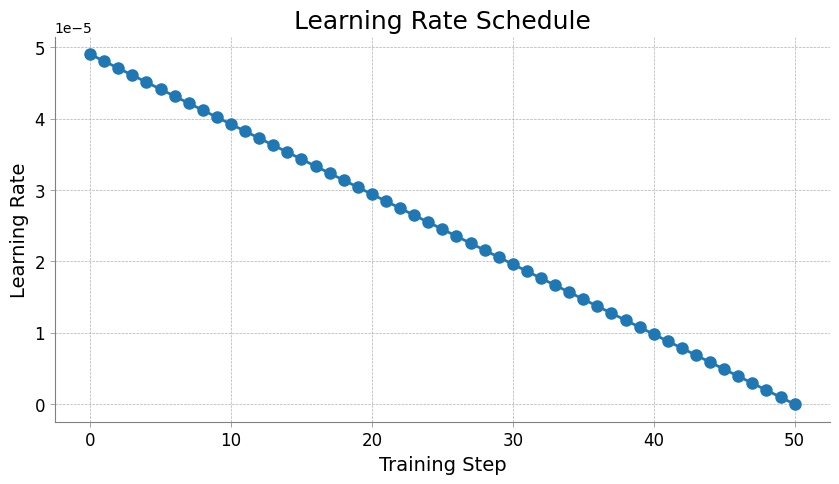

In [42]:
plt.figure(figsize=(10, 5))  # 设置图像大小
plt.plot(np.arange(len(loss_callback.learning_rates)), loss_callback.learning_rates, linewidth=2, marker='o', markersize=8)  # 设置线宽、标记和标记大小
plt.xlabel('Training Step', fontsize=14)  # 设置 x 轴标签和字体大小
plt.ylabel('Learning Rate', fontsize=14)  # 设置 y 轴标签和字体大小
plt.title('Learning Rate Schedule', fontsize=18)  # 设置标题和字体大小
plt.grid(True, linestyle='--', linewidth=0.5)  # 添加网格线
plt.xticks(fontsize=12)  # 设置 x 轴刻度字体大小
plt.yticks(fontsize=12)  # 设置 y 轴刻度字体大小

# 添加轴标签、标记和线条的颜色
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('gray')
plt.gca().spines['bottom'].set_color('gray')
plt.gca().xaxis.set_tick_params(width=0.5, color='gray')
plt.gca().yaxis.set_tick_params(width=0.5, color='gray')

plt.show()

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
device

device(type='cuda')

In [31]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [33]:
def predict(sentence, table, model, tokenizer, max_length=128):
    inputs = tokenizer(
        f"{sentence} [SEP] {table}",
        return_tensors="pt",
        max_length=max_length,
        padding="max_length",
        truncation=True
    )

    # 将输入数据移动到相同的设备
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=-1).item()

    return prediction


In [37]:
# 示例输入
sentence = "What is the name of the product with the lowest sales?"
table = "id name product_id quantity sale_date"

# 预测
prediction = predict(sentence, table, model, tokenizer)

# 输出预测结果
if prediction == 1:
    print("The input sentence can be converted into an SQL query using the provided table.")
else:
    print("The input sentence cannot be converted into an SQL query using the provided table.")

The input sentence cannot be converted into an SQL query using the provided table.


In [1]:
# 指定保存目录
save_directory = "./model"

# 保存模型
model.save_pretrained(save_directory)

# 保存分词器
tokenizer.save_pretrained(save_directory)

NameError: name 'model' is not defined